*** using Deep Learning Keras ***

# Volatility Forecasting


In [25]:
# tensorflow libs
from tensorflow.keras import models, layers, Input

#import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')

In [26]:
stocks = '^GSPC'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2022, 8, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')

s_p500.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3165 entries, 2010-01-04 to 2022-07-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3165 non-null   float64
 1   High       3165 non-null   float64
 2   Low        3165 non-null   float64
 3   Close      3165 non-null   float64
 4   Adj Close  3165 non-null   float64
 5   Volume     3165 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 173.1 KB


In [27]:
#Business Understanding
s_p500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
...,...,...,...,...,...,...
2022-07-25,3965.719971,3975.300049,3943.459961,3966.840088,3966.840088,3568340000
2022-07-26,3953.219971,3953.219971,3910.739990,3921.050049,3921.050049,3778950000
2022-07-27,3951.429932,4039.560059,3951.429932,4023.610107,4023.610107,4112180000


In [28]:
# Data Understanding
#Calculating the returns of the S&P 500 based on adjusted closing prices.
ret = 100 * (s_p500.pct_change()[1:]['Adj Close']) 
realized_vol = ret.rolling(5).std()

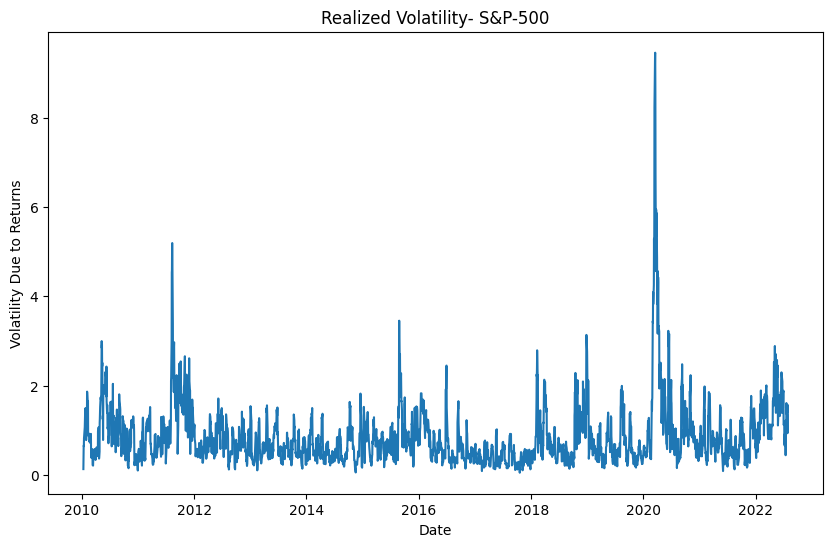

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- S&P-500')
plt.ylabel('Volatility Due to Returns')
plt.xlabel('Date')
plt.show()

In [30]:
#Calculating the volume of the S&P 500 
volume = 100* (s_p500.pct_change()[1:]['Volume']) 
realized_volume = volume.rolling(5).std()

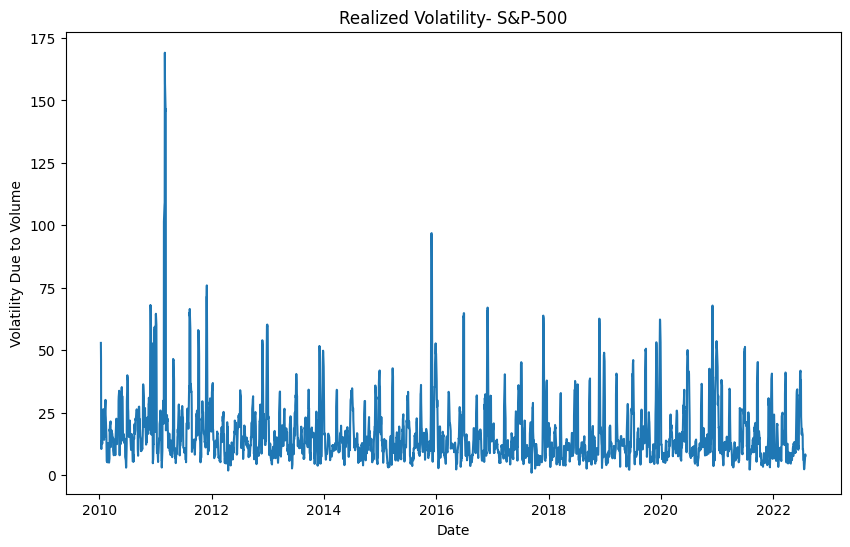

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(realized_volume.index,realized_volume)
plt.title('Realized Volatility- S&P-500')
plt.ylabel('Volatility Due to Volume')
plt.xlabel('Date')
plt.show()

In [32]:
#Data Preparation
#Computing realized volatility and assigning a new variable to it named realized_vol
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']

X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)
realized_vol.index = ret.iloc[4:].index

In [33]:
realized_vol.head()

,Adj Close
Date,
2010-01-11,0.133763
2010-01-12,0.537728
2010-01-13,0.658062
2010-01-14,0.646860
2010-01-15,0.823912


In [34]:
X.head()

,0,1
0,0.133763,0.030512
1,0.537728,0.880063
2,0.658062,0.693210
3,0.646860,0.058875
4,0.823912,1.171401


In [35]:
#Computing realized volatility and assigning a new variable to it named realized_volume on the basis of volume
realized_volume = pd.DataFrame(realized_volume)
realized_volume.reset_index(drop=True, inplace=True)


X_volume = pd.concat([realized_volume, returns_svm], axis=1, ignore_index=True)
X_volume = X_volume[4:].copy()
X_volume = X_volume.reset_index()
X_volume.drop('index', axis=1, inplace=True)

realized_volume = realized_volume.dropna().reset_index()
realized_volume.drop('index', axis=1, inplace=True)
realized_volume.index = ret.iloc[4:].index

In [36]:
realized_volume.head()

,Volume
Date,
2010-01-11,52.907227
2010-01-12,46.091025
2010-01-13,11.547859
2010-01-14,10.430867
2010-01-15,13.554089


In [37]:
returns_svm.head()

,Adj Close
0,0.097074
1,0.002976
2,0.160096
3,0.083044
4,0.030512


In [38]:
X_volume.head()

,0,1
0,52.907227,0.030512
1,46.091025,0.880063
2,11.547859,0.693210
3,10.430867,0.058875
4,13.554089,1.171401


In [39]:
# Modeling
model = models.Sequential(
             [layers.Dense(256, activation="relu"),
              layers.Dense(128, activation="relu"),
              layers.Dense(1, activation="linear"),]) 

In [40]:
model.compile(loss='mse', optimizer='rmsprop')

In [41]:
epochs_trial = np.arange(100, 400, 4)
batch_trial = np.arange(100, 400, 4)

In [42]:
# Data Fitting and Evaluation
DL_pred = []
DL_RMSE = []
n = 252

for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
              realized_vol.iloc[1:-(n-1)].values.reshape(-1,),
              batch_size=k, epochs=j, verbose=False)
             
    DL_predict = model.predict(np.asarray(X.iloc[-n:])) 
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] / 100,
    DL_predict.flatten() / 100))) 
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))

    

8/8 [==============================] - 0s 3ms/step
DL_RMSE_1:0.000722
8/8 [==============================] - 0s 2ms/step
DL_RMSE_2:0.000945
8/8 [==============================] - 0s 29ms/step
DL_RMSE_3:0.001609
8/8 [==============================] - 0s 2ms/step
DL_RMSE_4:0.000671


In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               768       
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33,793
Trainable params: 33,793
Non-trainable params: 0
_________________________________________________________________


In [44]:
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = ret.iloc[-n:].index


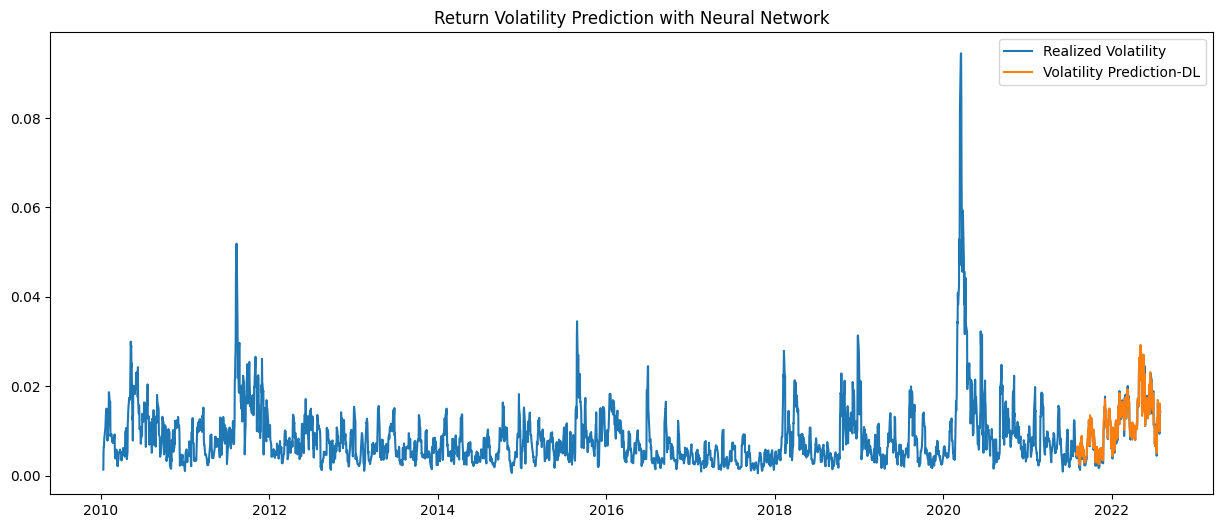

In [45]:
# Prediction
plt.figure(figsize=(15, 6))
plt.plot(realized_vol / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Return Volatility Prediction with Neural Network',  fontsize=12)
plt.legend()
plt.show()

In [46]:
# Data Fitting and Evaluation
DL_pred = []
DL_RMSE = []
X=X_volume
n = 252

for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
              realized_volume.iloc[1:-(n-1)].values.reshape(-1,),
              batch_size=k, epochs=j, verbose=False)
             
    DL_predict = model.predict(np.asarray(X.iloc[-n:])) 
    DL_RMSE.append(np.sqrt(mse(realized_volume.iloc[-n:] / 100,
    DL_predict.flatten() / 100))) 
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))
    

8/8 [==============================] - 0s 4ms/step
DL_RMSE_1:0.024842
8/8 [==============================] - 0s 2ms/step
DL_RMSE_2:0.014756
8/8 [==============================] - 0s 2ms/step
DL_RMSE_3:0.016429
8/8 [==============================] - 0s 2ms/step
DL_RMSE_4:0.021353


In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               768       
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33,793
Trainable params: 33,793
Non-trainable params: 0
_________________________________________________________________


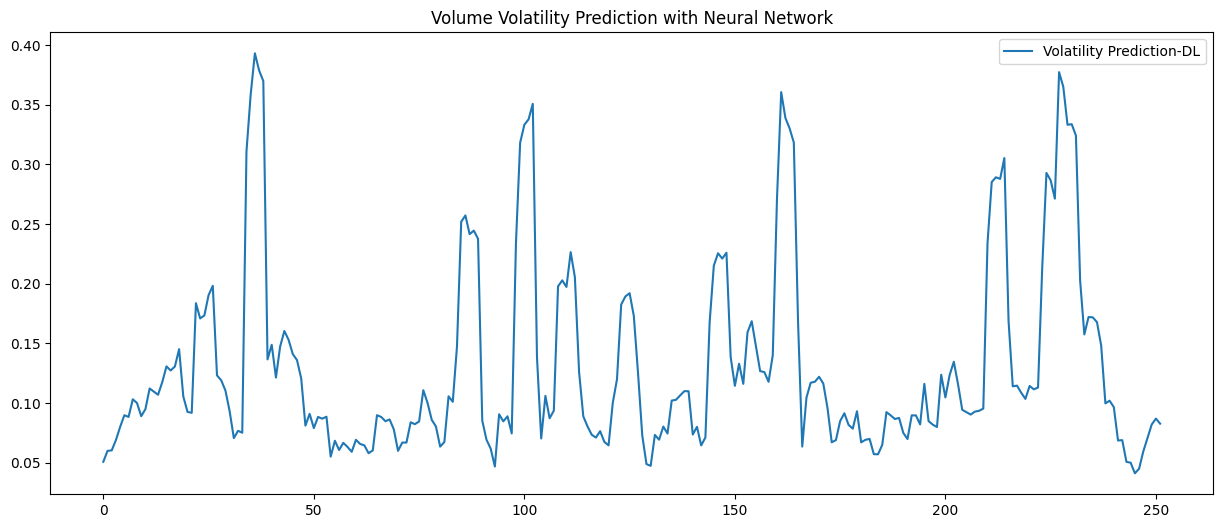

In [48]:
# prediction
plt.figure(figsize=(15, 6))
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Volume Volatility Prediction with Neural Network',  fontsize=12)
plt.legend()
plt.show()